# Preparatory Operations

In [58]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [59]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [60]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,SST,line_type,var_name):

    # plot
    plot_date(time,SST,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [61]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

In [62]:
from google.colab import auth
auth.authenticate_user()

# BigQuerry

Using BigQuerry get the data about SST and SSH in the south of Japan and the gulf of Mexico for everyday from 1998 to 2015

In [63]:
#Japan

%%bigquery output --project alert-ground-261008
SELECT lon, lat, time, ssh, sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>120 AND lon<145 AND lat>20 AND lat<40
ORDER BY time


Query is running:   0%|          |

Downloading:   0%|          |

In [64]:
#Mexico
"""
%%bigquery output --project alert-ground-261008
SELECT lon, lat, time, ssh, sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>256 AND lon<282 AND lat>18 AND lat<32
ORDER BY time
"""

'\n%%bigquery output --project alert-ground-261008\nSELECT lon, lat, time, ssh, sst\nFROM bdo2020.bdo2020.1998_2015\nWHERE lon>256 AND lon<282 AND lat>18 AND lat<32\nORDER BY time\n'

In [65]:
output

,lon,lat,time,ssh,sst
0,124.125,31.875,729390.0,0.6241,14.85
1,126.125,32.125,729390.0,0.7607,16.95
2,122.625,34.125,729390.0,0.6136,12.00
3,121.875,35.125,729390.0,0.5854,10.20
4,123.875,35.625,729390.0,0.6045,10.50
...,...,...,...,...,...
35366177,134.125,24.375,735963.0,1.4664,25.80
35366178,129.875,21.875,735963.0,1.5311,25.05
35366179,131.875,25.125,735963.0,1.4103,25.05
35366180,120.375,20.375,735963.0,0.9317,24.30


# Preparation of the dataset

Cut the map in subsquares in order to get the min sst per regions

In [69]:
#Function to plot the diff_sst between days
def plot_derivative_ts(df):
  length = len(df)

  plot_ts(df['time'], df['diff_sst'], '-*', 'Difference of temperature with the preceding day (°C)')

In [70]:
#Separate the lat and lon in bins

bins_lon = pd.cut(output.lon, 4, labels=['1', '2', '3', '4'])
bins_lat = pd.cut(output.lat, 4, labels=['A', 'B', 'C', 'D'])

In [73]:
#Add in which bins each lon and lat belong

output['bins_lat'] = bins_lat
output['bins_lon'] = bins_lon 

output

,lon,lat,time,ssh,sst,bins_lat,bins_lon
0,124.125,31.875,729390.0,0.6241,14.85,C,1
1,126.125,32.125,729390.0,0.7607,16.95,C,1
2,122.625,34.125,729390.0,0.6136,12.00,C,1
3,121.875,35.125,729390.0,0.5854,10.20,D,1
4,123.875,35.625,729390.0,0.6045,10.50,D,1
...,...,...,...,...,...,...,...
35366177,134.125,24.375,735963.0,1.4664,25.80,A,3
35366178,129.875,21.875,735963.0,1.5311,25.05,A,2
35366179,131.875,25.125,735963.0,1.4103,25.05,B,2
35366180,120.375,20.375,735963.0,0.9317,24.30,A,1


In [75]:
#Compute the min SST of the region for everyday in each square of the grid for a dataframe

def get_min_derivative_sst(df):
  bins_lat = ['A', 'B', 'C', 'D']
  bins_lon = ['1', '2', '3', '4']

  df_result = output.groupby(['time']).mean().reset_index()
  length = len(df_result)
  derivative_sst = zeros((length))
  derivative_sst[1:] = df_result['sst'].to_numpy()[1:] - df_result['sst'].to_numpy()[:length-1]
  df_result['diff_sst'] = derivative_sst

  for cat_lat in bins_lat:
    for cat_lon in bins_lon:
      df_temp = df[df['bins_lat'] == cat_lat][df['bins_lon'] == cat_lon]
      length = len(df_temp)
      derivative_sst = zeros((length))
      derivative_sst[1:] = df_temp['sst'].to_numpy()[1:] - df_temp['sst'].to_numpy()[:length-1]

      for i in range(length):
        if derivative_sst[i] < df_result.iloc[i]['diff_sst']:
          df_result.iloc[i]['diff_sst'] = derivative_sst[i]
    return df_result

In [76]:
#Create a working dataframe
sst_ts_df = get_min_derivative_sst(output.groupby(['time', 'bins_lat', 'bins_lon']).mean().reset_index())

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst
0,729390.0,134.013093,28.169885,1.166013,21.130445,0.000000
1,729391.0,134.013093,28.169885,1.163381,21.134655,0.004211
2,729392.0,134.013093,28.169885,1.160821,21.135870,0.001215
3,729393.0,134.013093,28.169885,1.158622,21.180859,0.044989
4,729394.0,134.013093,28.169885,1.156822,21.224689,0.043830
...,...,...,...,...,...,...
6569,735959.0,134.048422,28.373473,1.233603,21.959162,-0.012965
6570,735960.0,134.048422,28.373473,1.231150,21.819795,-0.139367
6571,735961.0,134.048422,28.373473,1.229185,21.654470,-0.165325
6572,735962.0,134.048422,28.373473,1.227793,21.683953,0.029484


# Plots

In [74]:
#Set a threshold for which we'll consider a hurricane occured
threshold = -0.33

In [77]:
derivative_sst = sst_ts_df['diff_sst'].to_numpy()

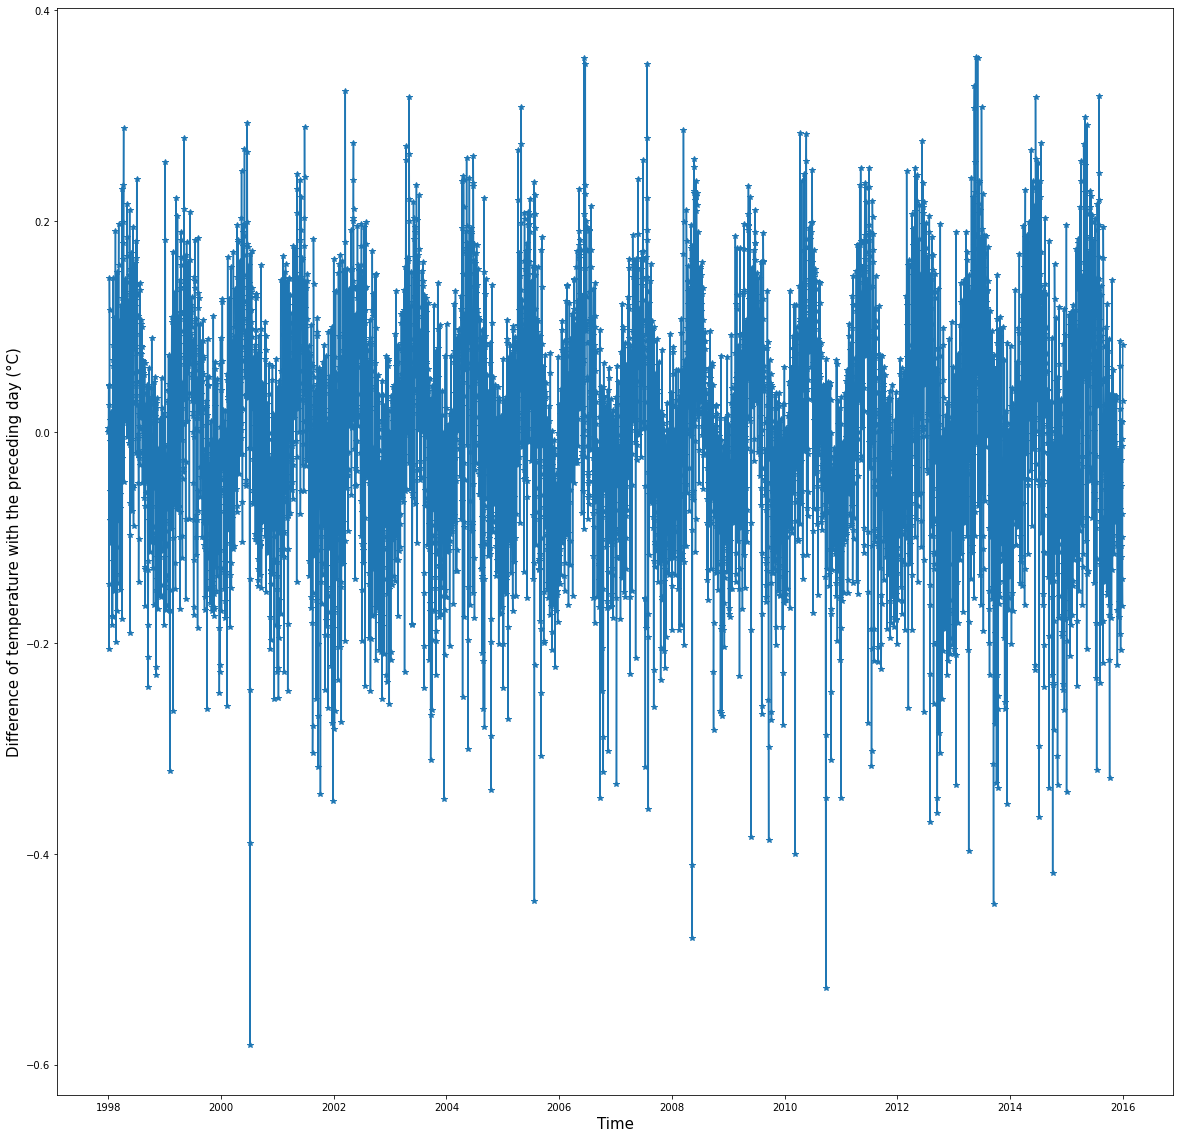

In [78]:
plot_derivative_ts(sst_ts_df)
title('Derivative of the SST for every year')

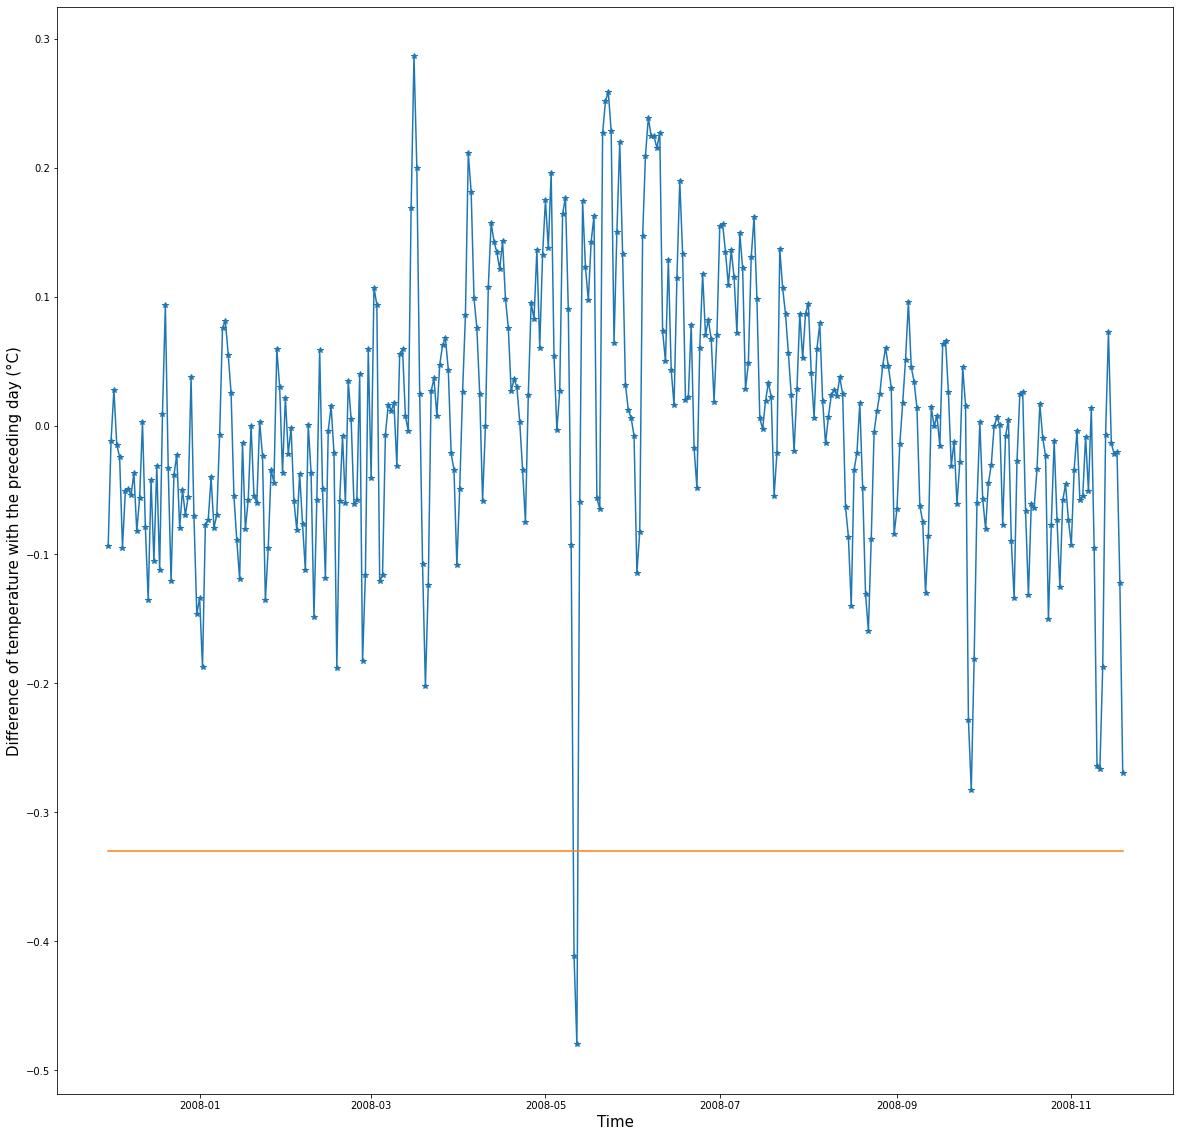

In [79]:
plot_derivative_ts(sst_ts_df.iloc[3620:3976])
plot_ts(sst_ts_df.iloc[3620:3976]['time'], np.array([threshold for i in range(3620,3976)]), '-', 'Difference of temperature with the preceding day (°C)')
title('Derivative of the SST in 2008')

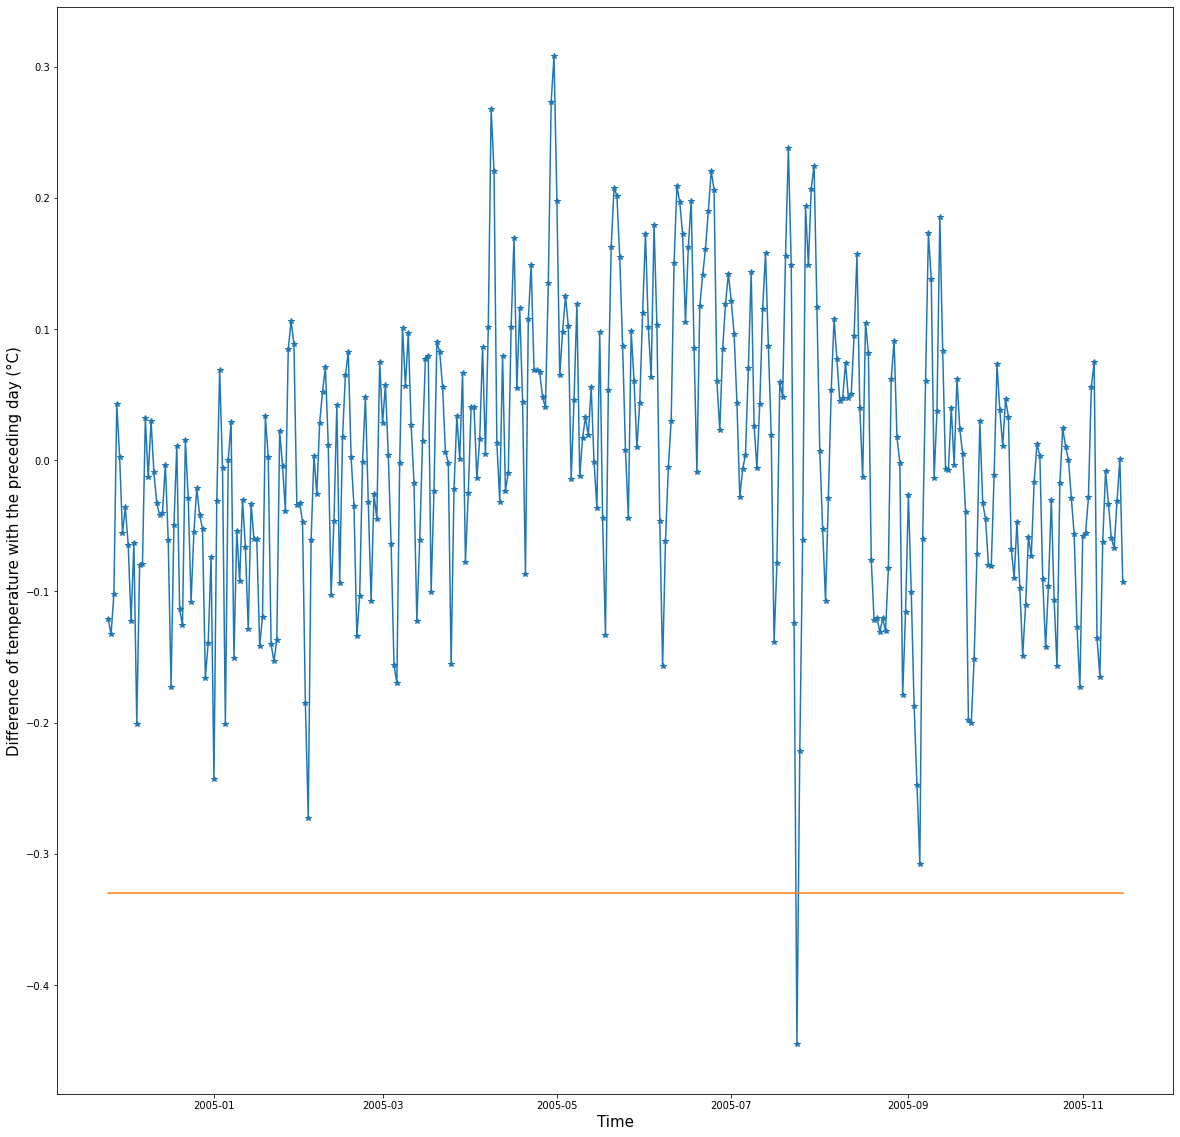

In [80]:
plot_derivative_ts(sst_ts_df.iloc[2520:2876])
plot_ts(sst_ts_df.iloc[2520:2876]['time'],np.array([threshold for i in range(2876-2520)]), '-', 'Difference of temperature with the preceding day (°C)')
title('Derivative of the SST in 2005')

In [81]:
#Count the number of typhoon
sst_ts_df.loc[sst_ts_df['diff_sst'] < threshold].count()['diff_sst']

32

In [82]:
#Get a predictive model of the seasonal cycles of the derivative of the sst and substract it to put a threshold
from sklearn import linear_model

omega = 1/365.25

X = zeros((6574,3))
y = sst_ts_df['diff_sst'].to_numpy()

time = sst_ts_df['time'].to_numpy()

X[:,0] = time
X[:,1] = sin(2 * pi * omega * time)
X[:,2] = cos(2 * pi * omega * time)

model = linear_model.LinearRegression()

model.fit(X,y)

y_pred = model.predict(X)

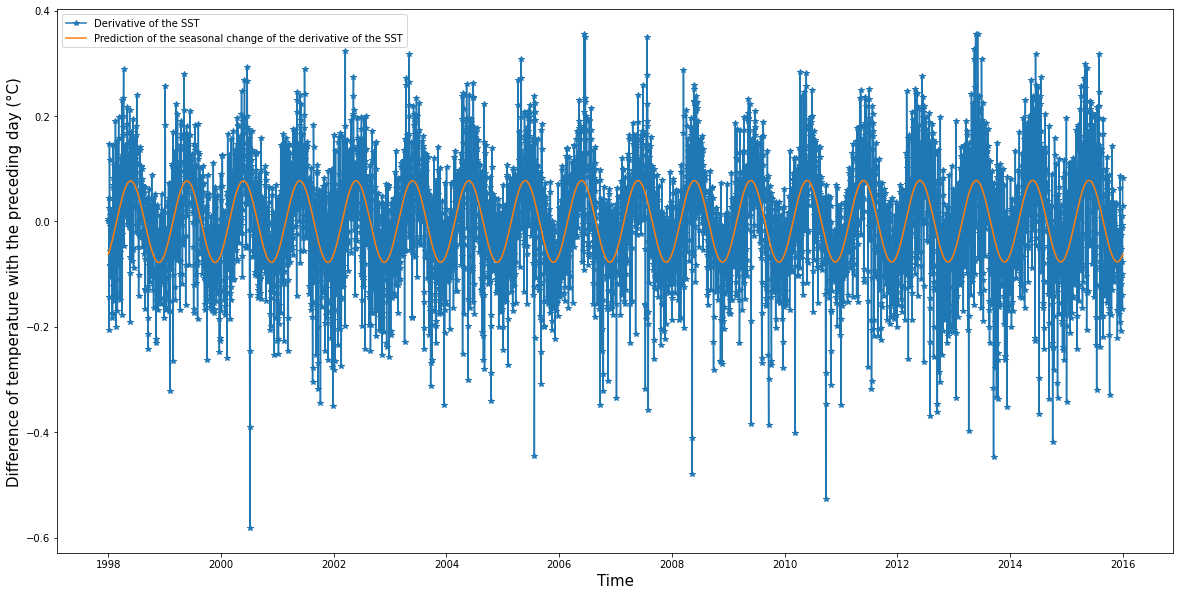

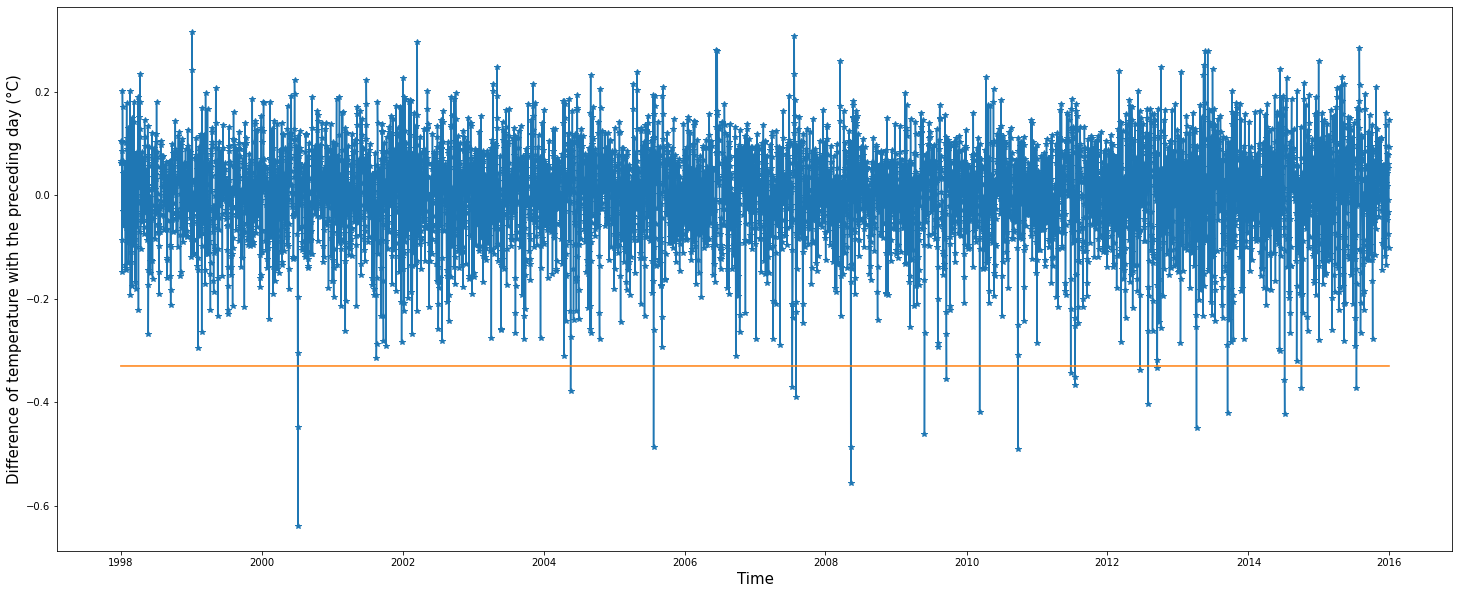

In [111]:
plot_derivative_ts(sst_ts_df)
plot(X[:,0], y_pred)
legend(['Derivative of the SST', 'Prediction of the seasonal change of the derivative of the SST'])
figure(figsize=(25,10))
plot_ts(time, derivative_sst-y_pred, '-*', 'Prediction of temperature')
plot_ts(sst_ts_df['time'],np.array([threshold for i in range(6574)]), '-', 'Difference of temperature with the preceding day (°C)')

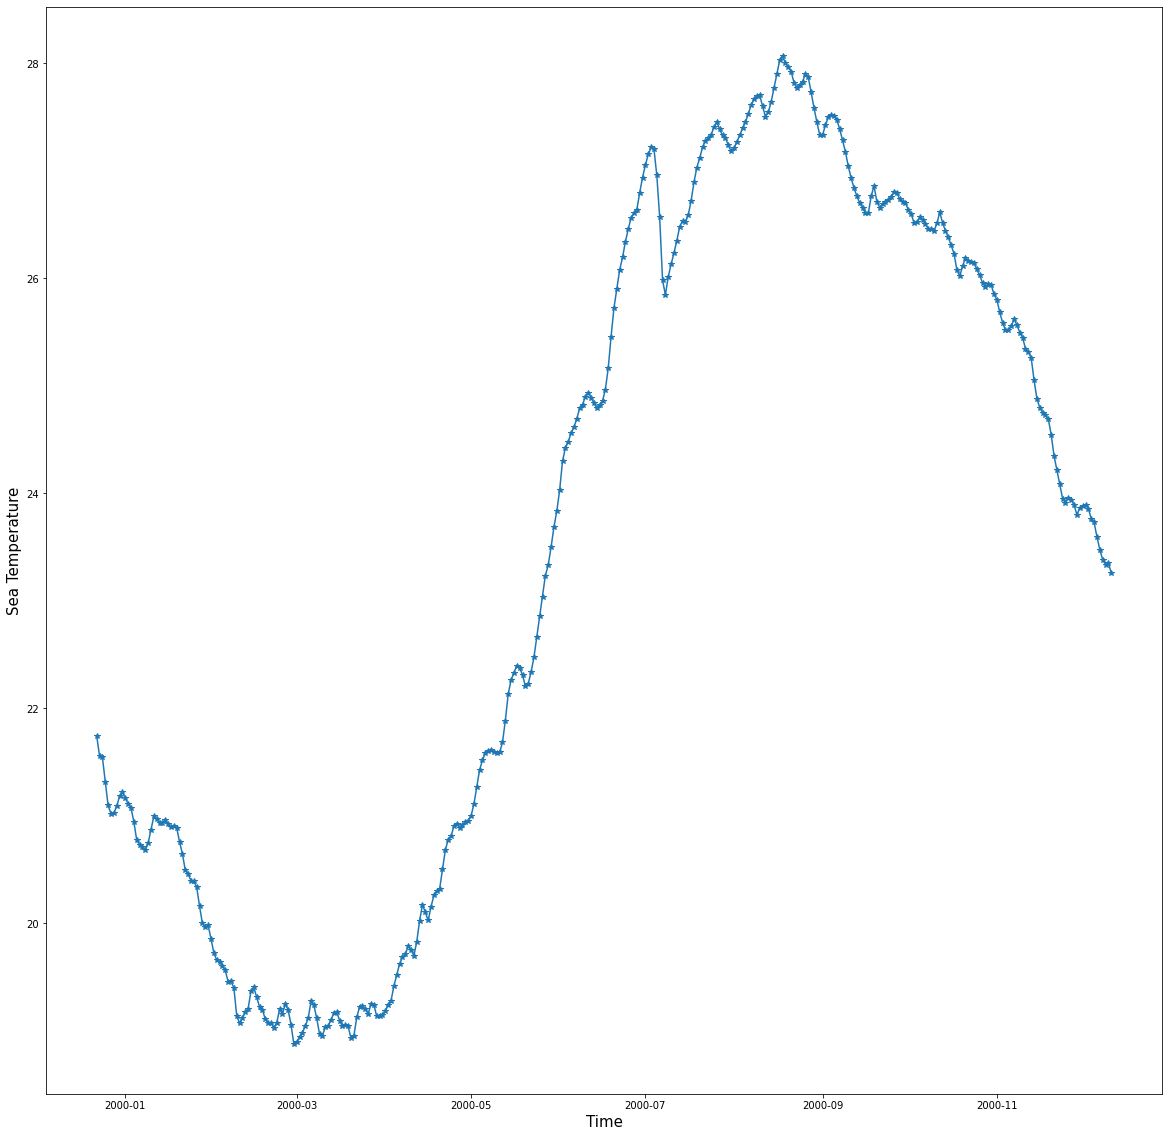

In [84]:
plot_ts(sst_ts_df.iloc[720:1076]['time'], sst_ts_df.iloc[720:1076]['sst'], '-*', 'Sea Temperature')

By plotting the SST we can see that the typhoon that occured in 2000 in Japan created a drop at the date of the hurricane

In [86]:
#Count the typhoon and the dates where they occured
count_typhoon_array = zeros(len(sst_ts_df))
for i in range(1,len(sst_ts_df)):
  if sst_ts_df.iloc[i]['diff_sst'] <= threshold:
    count_typhoon_array[i] = count_typhoon_array[i-1] + 1
  else:
    count_typhoon_array[i] = count_typhoon_array[i-1]

sst_ts_df['typhoon_count'] = count_typhoon_array

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count
0,729390.0,134.013093,28.169885,1.166013,21.130445,0.000000,0.0
1,729391.0,134.013093,28.169885,1.163381,21.134655,0.004211,0.0
2,729392.0,134.013093,28.169885,1.160821,21.135870,0.001215,0.0
3,729393.0,134.013093,28.169885,1.158622,21.180859,0.044989,0.0
4,729394.0,134.013093,28.169885,1.156822,21.224689,0.043830,0.0
...,...,...,...,...,...,...,...
6569,735959.0,134.048422,28.373473,1.233603,21.959162,-0.012965,32.0
6570,735960.0,134.048422,28.373473,1.231150,21.819795,-0.139367,32.0
6571,735961.0,134.048422,28.373473,1.229185,21.654470,-0.165325,32.0
6572,735962.0,134.048422,28.373473,1.227793,21.683953,0.029484,32.0


In [87]:
import matplotlib.dates as mdates
from datetime import datetime

year_in_df = zeros(len(sst_ts_df))
for i in range(len(sst_ts_df)):
  matplotlib_date = sst_ts_df.iloc[i]['time']
  date = mdates.num2date(matplotlib_date)
  year_in_df[i] = date.year

sst_ts_df['year'] = year_in_df

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,year
0,729390.0,134.013093,28.169885,1.166013,21.130445,0.000000,0.0,1998.0
1,729391.0,134.013093,28.169885,1.163381,21.134655,0.004211,0.0,1998.0
2,729392.0,134.013093,28.169885,1.160821,21.135870,0.001215,0.0,1998.0
3,729393.0,134.013093,28.169885,1.158622,21.180859,0.044989,0.0,1998.0
4,729394.0,134.013093,28.169885,1.156822,21.224689,0.043830,0.0,1998.0
...,...,...,...,...,...,...,...,...
6569,735959.0,134.048422,28.373473,1.233603,21.959162,-0.012965,32.0,2015.0
6570,735960.0,134.048422,28.373473,1.231150,21.819795,-0.139367,32.0,2015.0
6571,735961.0,134.048422,28.373473,1.229185,21.654470,-0.165325,32.0,2015.0
6572,735962.0,134.048422,28.373473,1.227793,21.683953,0.029484,32.0,2015.0


In [88]:
month_in_df = zeros(len(sst_ts_df))
for i in range(len(sst_ts_df)):
  matplotlib_date = sst_ts_df.iloc[i]['time']
  date = mdates.num2date(matplotlib_date)
  month_in_df[i] = date.month

sst_ts_df['month'] = month_in_df

sst_ts_df

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,year,month
0,729390.0,134.013093,28.169885,1.166013,21.130445,0.000000,0.0,1998.0,1.0
1,729391.0,134.013093,28.169885,1.163381,21.134655,0.004211,0.0,1998.0,1.0
2,729392.0,134.013093,28.169885,1.160821,21.135870,0.001215,0.0,1998.0,1.0
3,729393.0,134.013093,28.169885,1.158622,21.180859,0.044989,0.0,1998.0,1.0
4,729394.0,134.013093,28.169885,1.156822,21.224689,0.043830,0.0,1998.0,1.0
...,...,...,...,...,...,...,...,...,...
6569,735959.0,134.048422,28.373473,1.233603,21.959162,-0.012965,32.0,2015.0,12.0
6570,735960.0,134.048422,28.373473,1.231150,21.819795,-0.139367,32.0,2015.0,12.0
6571,735961.0,134.048422,28.373473,1.229185,21.654470,-0.165325,32.0,2015.0,12.0
6572,735962.0,134.048422,28.373473,1.227793,21.683953,0.029484,32.0,2015.0,12.0


In [90]:
df_nb_typhoon_per_year = sst_ts_df.groupby(['year']).max()
years = df_nb_typhoon_per_year.index.to_numpy()
nb_typhoon_per_year = zeros(len(df_nb_typhoon_per_year))
count = 0
for year in range(0,18):
  nb_typhoon_per_year[year] = df_nb_typhoon_per_year.iloc[year]['typhoon_count'] - count
  count = df_nb_typhoon_per_year.iloc[year]['typhoon_count']

df_nb_typhoon_per_year['nb_typhoon_per_year'] = nb_typhoon_per_year

In [91]:
df_nb_typhoon_per_year

,time,lon,lat,ssh,sst,diff_sst,typhoon_count,month,nb_typhoon_per_year
year,,,,,,,,,
1998.0,729754.0,134.013093,28.169885,1.261144,28.900122,0.288725,0.0,12.0,0.0
1999.0,730119.0,134.013093,28.169885,1.272061,28.538235,0.279371,0.0,12.0,0.0
2000.0,730485.0,134.013093,28.169885,1.261729,28.068849,0.293359,2.0,12.0,2.0
2001.0,730850.0,134.013093,28.169885,1.299681,28.921034,0.289346,4.0,12.0,2.0
2002.0,731215.0,134.048422,28.373473,1.271521,28.023237,0.323879,4.0,12.0,0.0
2003.0,731580.0,134.048422,28.373473,1.288625,28.451055,0.318212,5.0,12.0,1.0
2004.0,731946.0,134.048422,28.373473,1.267634,28.321377,0.261910,6.0,12.0,1.0
2005.0,732311.0,134.048422,28.373473,1.281492,28.594753,0.308107,7.0,12.0,1.0
2006.0,732676.0,134.048422,28.373473,1.267887,28.674014,0.355330,8.0,12.0,1.0


Text(0.5, 1.0, 'Frequency of typhoon per year')

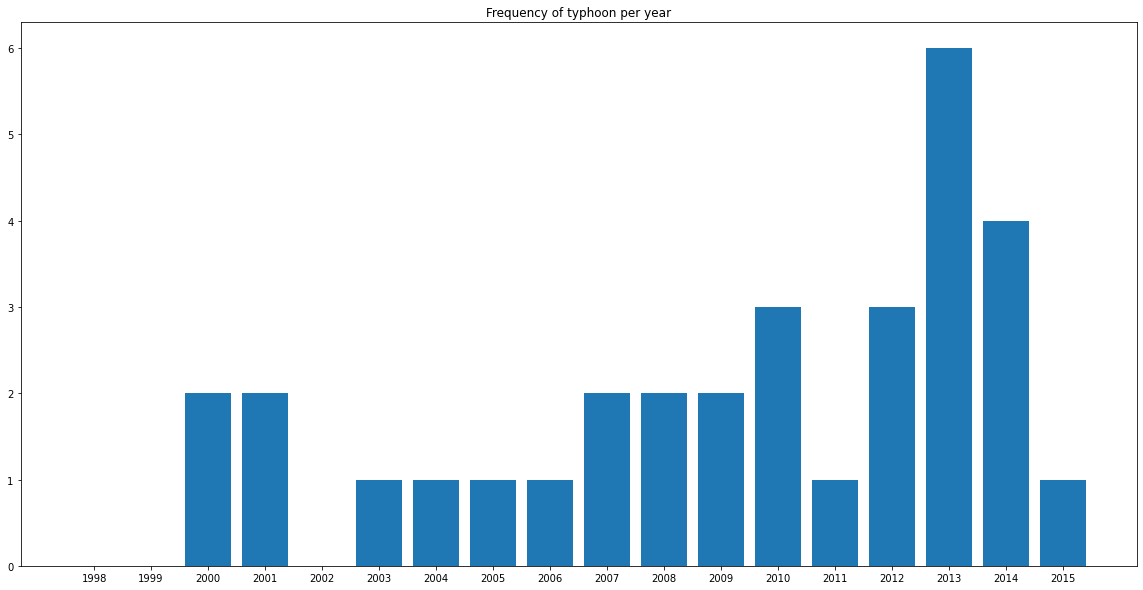

In [112]:
figure(figsize(20,10))
bar(df_nb_typhoon_per_year.index.to_numpy(), df_nb_typhoon_per_year['nb_typhoon_per_year'].to_numpy())
plt.xticks(df_nb_typhoon_per_year.index.to_numpy())
title('Frequency of typhoon per year')

In [93]:
df_nb_typhoon_per_year.to_csv('df_nb_typhoon_per_year.csv', index=False)

In [94]:
df_nb_typhoon_per_month = sst_ts_df.groupby(['year','month']).mean()
df_nb_typhoon_per_month.reset_index(inplace=True)

# Precision and Recall of the detection method

Using a real dataset of data from NOA, we'll compare our detection method with what happenned. In order to do so, we will compare the dates where there was a significant drop of SST with the dates where a cyclone occurred

In [98]:
df_ibtracs = pd.read_csv('ibtracs-japan-1998-2015.csv')

In [99]:
df_ibtracs['ISO_TIME']

0       1998-07-08 06:00:00
1       1998-07-08 09:00:00
2       1998-07-08 12:00:00
3       1998-07-08 15:00:00
4       1998-07-08 18:00:00
               ...         
7322    2015-11-26 00:00:00
7323    2015-11-26 03:00:00
7324    2015-11-26 06:00:00
7325    2015-11-26 09:00:00
7326    2015-11-26 12:00:00
Name: ISO_TIME, Length: 7327, dtype: object

In [100]:
df_ibtracs['NSEC_TIME'] = pd.to_datetime(df_ibtracs.NSEC_TIME, format='%Y-%m-%d %H:%M:%S')

df_ibtracs['days'] = df_ibtracs['NSEC_TIME'].dt.round('D')

In [101]:
matplotlib_date = 735963.0
date = mdates.num2date(matplotlib_date)
date

datetime.datetime(2015, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)

In [102]:
df_ibtracs

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,days
0,20.086,129.000,1998187N17132,30.0,TD,1998-07-08 06:00:00,1998-07-08 06:00:00,1998-07-08
1,20.254,128.858,1998187N17132,30.0,TD,1998-07-08 09:00:00,1998-07-08 09:00:00,1998-07-08
2,20.450,128.700,1998187N17132,30.0,TD,1998-07-08 12:00:00,1998-07-08 12:00:00,1998-07-09
3,20.632,128.575,1998187N17132,30.0,TD,1998-07-08 15:00:00,1998-07-08 15:00:00,1998-07-09
4,20.800,128.450,1998187N17132,30.0,TD,1998-07-08 18:00:00,1998-07-08 18:00:00,1998-07-09
...,...,...,...,...,...,...,...,...
7322,22.492,138.492,2015321N04164,35.0,TS,2015-11-26 00:00:00,2015-11-26 00:00:00,2015-11-26
7323,23.070,139.046,2015321N04164,35.0,TS,2015-11-26 03:00:00,2015-11-26 03:00:00,2015-11-26
7324,23.700,139.775,2015321N04164,35.0,TS,2015-11-26 06:00:00,2015-11-26 06:00:00,2015-11-26
7325,24.435,140.711,2015321N04164,35.0,TS,2015-11-26 09:00:00,2015-11-26 09:00:00,2015-11-26


In [103]:
dates_cyclones = zeros(len(df_ibtracs))

for i in range(len(df_ibtracs)):
  date_days = df_ibtracs['days'].iloc[i]
  date = datetime(date_days.year, date_days.month, date_days.day)
  matplotlib_date = mdates.date2num(date)
  dates_cyclones[i] = matplotlib_date

df_ibtracs['matplotlib_date'] = dates_cyclones
df_ibtracs

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,days,matplotlib_date
0,20.086,129.000,1998187N17132,30.0,TD,1998-07-08 06:00:00,1998-07-08 06:00:00,1998-07-08,729578.0
1,20.254,128.858,1998187N17132,30.0,TD,1998-07-08 09:00:00,1998-07-08 09:00:00,1998-07-08,729578.0
2,20.450,128.700,1998187N17132,30.0,TD,1998-07-08 12:00:00,1998-07-08 12:00:00,1998-07-09,729579.0
3,20.632,128.575,1998187N17132,30.0,TD,1998-07-08 15:00:00,1998-07-08 15:00:00,1998-07-09,729579.0
4,20.800,128.450,1998187N17132,30.0,TD,1998-07-08 18:00:00,1998-07-08 18:00:00,1998-07-09,729579.0
...,...,...,...,...,...,...,...,...,...
7322,22.492,138.492,2015321N04164,35.0,TS,2015-11-26 00:00:00,2015-11-26 00:00:00,2015-11-26,735928.0
7323,23.070,139.046,2015321N04164,35.0,TS,2015-11-26 03:00:00,2015-11-26 03:00:00,2015-11-26,735928.0
7324,23.700,139.775,2015321N04164,35.0,TS,2015-11-26 06:00:00,2015-11-26 06:00:00,2015-11-26,735928.0
7325,24.435,140.711,2015321N04164,35.0,TS,2015-11-26 09:00:00,2015-11-26 09:00:00,2015-11-26,735928.0


In [104]:
sst_ts_df

dates_experimental_cyclones = []

for i in range(1,6574):
  if sst_ts_df.iloc[i]['typhoon_count'] > sst_ts_df.iloc[i-1]['typhoon_count']:
    dates_experimental_cyclones.append(sst_ts_df.iloc[i]['time'])

dates_experimental_cyclones

[730307.0,
 730308.0,
 730765.0,
 730845.0,
 731565.0,
 731871.0,
 732151.0,
 732577.0,
 732683.0,
 732889.0,
 733173.0,
 733174.0,
 733555.0,
 733669.0,
 733841.0,
 734039.0,
 734040.0,
 734138.0,
 734715.0,
 734761.0,
 734762.0,
 734882.0,
 734965.0,
 735126.0,
 735145.0,
 735156.0,
 735212.0,
 735422.0,
 735484.0,
 735509.0,
 735541.0,
 735599.0]

In [113]:
count_true = 0
count_false = 0
for i in dates_experimental_cyclones:
  if i in dates_cyclones:
    count_true += 1
  else:
    count_false += 1

print('Precision =', (count_true)/(count_true+count_false))

Precision = 0.6875


In [114]:
print("Recall =",count_true/len(dates_cyclones))

Recall = 0.003002593148628361


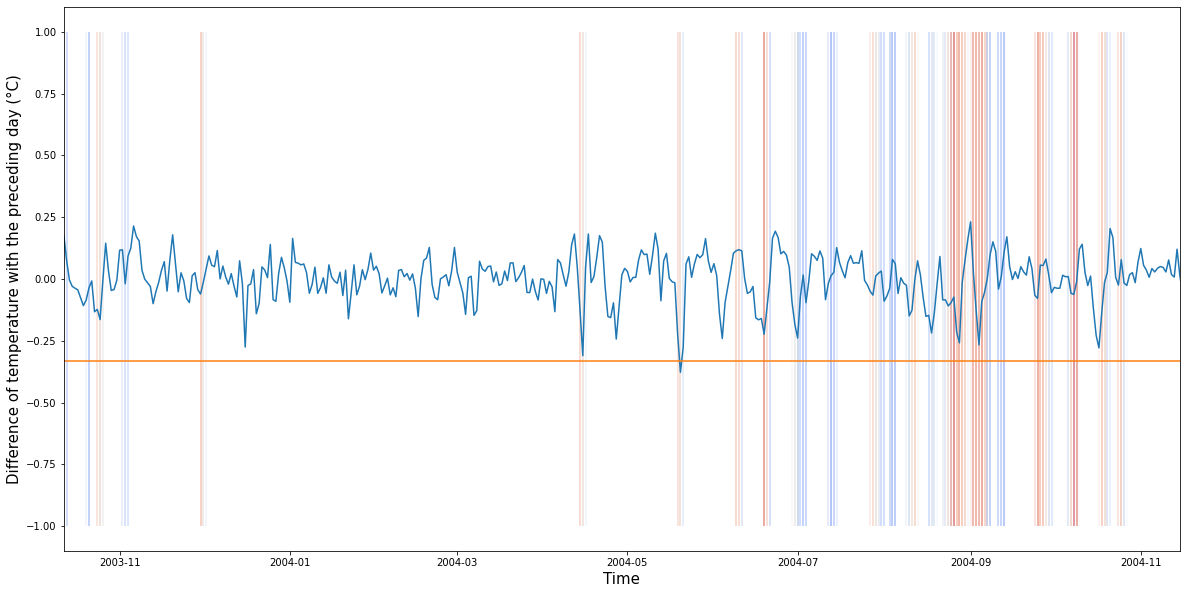

In [109]:
minTime = 731500.0
maxTime = 731900.0
cmap = matplotlib.cm.get_cmap("coolwarm")

for _, cycloneDated in df_ibtracs[(df_ibtracs["matplotlib_date"] < maxTime) & (df_ibtracs["matplotlib_date"] > minTime)][["USA_WIND","matplotlib_date"]].iterrows():
  lineColor = cmap(cycloneDated["USA_WIND"]/140)
  lineColor = (lineColor[0], lineColor[1], lineColor[2], 0.1)
  vlines(cycloneDated["matplotlib_date"], -1, 1, colors=lineColor)
xlim((minTime,maxTime))
plot_ts(sst_ts_df['time'],sst_ts_df['diff_sst']-y_pred, '-', 'Difference of temperature with the preceding day (°C)')
plot_ts(sst_ts_df['time'],np.array([threshold for i in range(6574)]), '-', 'Difference of temperature with the preceding day (°C)')